In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
%matplotlib inline
import pymongo as pm
from bson.code import Code

# MapReduce

This notebook contains a MapReduce version of linear regression. 


## Linear Regression

For the linear regression, we will build upon both the MongoDB as well as the streaming Regression Notebook.

First, let's create a Dataset:

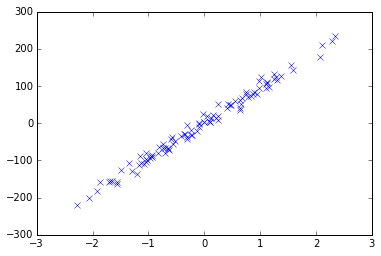

In [2]:
X,y = make_regression(n_samples=100, 
                      n_features=1, 
                      n_informative=1, 
                      n_targets=1, 
                      tail_strength=0.5, noise=10.0)
plt.plot(X,y,'x')

then start the MongoDB client and remove all data that might have stayed there from my extensive trial-and-error-Javascript programming:

In [3]:
client = pm.MongoClient()
db = client.test_database 
db.data.remove()

C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.
  app.launch_new_instance()


{'n': 100, 'ok': 1}

then safe the new data to the Database (mind the 'k':1; we need it to make your regression work. I'm pretty sure that's not something that's commonly needed, but, I have so little idea about how js works that... well it was a hack.)

In [4]:
for i in range(len(y)):
    datapoint = {'_id':i,
        'x':float(X[i]),
                'y': float(y[i]),
                'k':1}
    db.data.insert_one(datapoint)

the beautiful Javascript map and reduce functions. I was really stupid and tried to write and debug them IN THIS ENVIRONMENT instead of just opening up javascript. Well. My bad. 

The map function computes x*x and x*y (see the streaming regression Notebook),
the reduce function computes the sum to obtain A and b; in the end we need to do 1/A *b to obtain the thetas.

Mind: For simplicity (and lack of knowledge about javascript matrix operators), this Version ommits the fitting of the intercept. Instead, luckily, the dataset is centered around 0.

In [5]:
map = Code("function() {"
    "var value = {"
        "xx:this.x*this.x,"
           "xy:this.x*this.y};"
    "emit(this.k,value);"
"};")

In [6]:
reduce = Code("function (key,values) {"
             " var total = {xx:0,xy:0};"
             "for (var i = 0; i<values.length; i++){"
             "total.xx += values[i].xx;"
              "total.xy += values[i].xy;"
             "}"
             "return total;"
             "}")

In [7]:
results = db.data.map_reduce(map,reduce,'mything')

In [8]:
for doc in results.find():
    print(doc)

{'value': {'xy': 10182.657205420515, 'xx': 107.64955603769045}, '_id': 1.0}


In [9]:
doc['value']['xx']

107.64955603769045

In [10]:
beta = 1/doc['value']['xx'] * doc['value']['xy']

In [11]:
beta

94.59079610003543

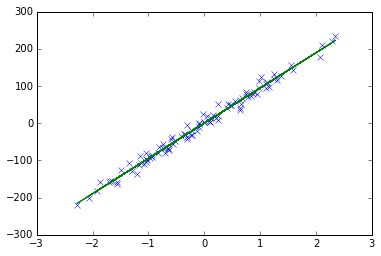

In [12]:
plt.plot(X,y,'x')
plt.plot(X,X*beta)

beautiful, right?